<a href="https://colab.research.google.com/github/swkravitz/phy-373-fall-2025/blob/main/01_Combining_Eigenstates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining Eigenstates


### Credit: Peter Onyisi
### Edits by Scott Kravitz, Fall 2025

In [1]:
# TACC: install if necessary
try:
    import numba
except:
    ! pip3 install --user numba numpy==1.19.1 scipy==1.5.2 tqdm==4.48.2
    INSTALL_PATH='/home/jupyter/mydata/jupyter_packages/lib/python3.6/site-packages'
    import sys, os
    if os.access(INSTALL_PATH, os.R_OK) and INSTALL_PATH not in sys.path:
        sys.path.insert(0, INSTALL_PATH)

# generic
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['animation.embed_limit'] = 60
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
import math
import numpy
import scipy.integrate
import scipy.stats
import scipy.special
from matplotlib import animation

## The Dynamics of Wave Functions

For classical particles, time evolution (*dynamics*) is handled by Newton's Second Law:

$$ m\frac{d^2 x}{dt^2} = F(x) = -\frac{dV}{dx} $$

in one dimension (where $V$ is the potential energy describing $F$, assuming we're only using conservative forces); in three dimensions we would write

$$ m\frac{d^2\vec{x}}{dt^2} = \vec{F}(\vec{x}) = -\nabla V(\vec{x}) $$

The equivalent for wave functions is a *partial differential equation*, the *time-dependent Schr&ouml;dinger equation*. For one dimension it is:

$$ i\hbar \frac{\partial \psi}{\partial t} = -\frac{\hbar^2}{2m}\frac{\partial^2 \psi}{\partial x^2} + V(x)\psi(x,t) $$

where we have $\hbar = h/2\pi$ and $V(x)$ is the potential energy as a function of $x$. Here we now allow the wave function to be a function of both position $x$ and time $t$: $\psi = \psi(x,t)$.

Just like with Newton's Second Law, this tells us about how a particle will evolve given its state at a certain time.  That is - if $\psi(x, t_0)$ is known, I can evaluate the right hand side of the equation for any value of $x$, and that tells me $\partial \psi/\partial t$ for that $x$.   To make this a little more explicit:

$$ \frac{\partial\psi}{\partial t} = \frac{1}{i\hbar}\left[-\frac{\hbar^2}{2m}\frac{\partial^2 \psi}{\partial x^2} + V(x)\psi(x,t)\right] $$

## Numerically Solving Partial Differential Equations

In general it is difficult or impossible to find analytic solutions for Schr&ouml;dinger's equation. (You may get the opposite impression in follow-up classes, in which you will spend a lot of time finding analytic solutions! But by definition you will be looking at the cases where analytic solutions are possible.)  Thankfully the time-dependent Schr&ouml;dinger equation is well suited to having a computer approximate the solution.

The general procedure is this:
* since we don't know an analytic form for the wave function, we approximate it by its values at a set of points, assuming it doesn't change too much between the points. In other words we _discretize_ space. We aren't going to be able to see effects that happen at a shorter distance than the spacing between the points, but our computational cost will go up as we have more points, so there is a tradeoff of accuracy for time.
* at any given point in space we can compute $V(x)\psi(x)$ easily. We can _approximate_ $\partial^2 \psi/\partial x^2$ by *finite differences*:
$$ \frac{\partial^2 \psi}{\partial x^2}(x_n) \approx \frac{\psi(x_{n+1})+\psi(x_{n-1})-2\psi(x_n)}{\Delta x^2} $$
* from this information we can determine $\partial \psi/\partial t$. Conceptually we can then use this to extrapolate a small time step into the future, at all grid points:
$$ \psi(x_n, t+\Delta t) \approx \psi(x_n, t) + \Delta t \frac{\partial \psi}{\partial t}(x_n) $$

In practice we make a couple of small modifications:
* Because the finite difference method assumes that there are neighbor grid points on both sides, we have a problem at the edges. We "solve" this by having the grid wrap around, so going off the right edge takes us to the left edge.
* There is a deep literature on how small a time step $\Delta t$ is needed to produce numerically reliable solutions. For the method outlined above, while it works, it requires very small time steps $\Delta t$ to produce good answers. There are more accurate ways to use $\partial\psi/\partial t$ to extrapolate to the future, which rely on effectively computing approximations to $\partial^2 \psi/\partial t^2$ and higher derivatives from $\partial \psi/\partial t$ at different times.  Here we use one of these methods (*Runge-Kutta 5*).

**For all computations here, we set *h*=1, so we don't have to deal with very small/large numbers.**

In [2]:
RNG=(-10,10) # range in x
PTS = 501
grid = numpy.linspace(RNG[0],RNG[1],PTS)[:-1] # drop last point, which wraps to initial point
deltaxsq = ((RNG[1]-RNG[0])/(PTS-1))**2

# define potential energy
V = numpy.zeros_like(grid)
#V = numpy.single(numpy.frompyfunc(lambda x: 20*numpy.sin(x*math.pi/2)**2, 1, 1)(grid))
#V = numpy.single(numpy.frompyfunc(lambda x: 100*x**2, 1, 1)(grid))

# we are going to set h (not hbar) = 1 and m = 1
# so that hbar = 1/(2*pi)

def d2psi(psi): # numerical second (spatial) derivative for some function (array) psi
    return numpy.diff(psi,n=2,prepend=psi[-1],append=psi[0])/deltaxsq

def dpsidt(t, psi): # time derivative of psi, directly from Schroedinger equation
    global V
    return -1.j*(2*math.pi*V*psi - d2psi(psi)/(2*2*math.pi))

# example starting wavefunction
P=1 # related to momentum expectation value; + means right-going
# Gaussian wave packet with right-going momentum
psi=numpy.csingle(scipy.stats.norm(scale=1,loc=-6).pdf(grid))*numpy.exp(2j*math.pi*P*grid)
# normalize psi
psi /= math.sqrt(sum(psi*psi.conj()).real*(RNG[1]-RNG[0])/(PTS-1))

In [3]:
# numerically integrate across times in TRNG
TRNG=(0,4)
TIMES=numpy.linspace(TRNG[0], TRNG[1], 100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES) # numerical integration across each time step
print("Done with integration")


Done with integration


## Particle in a Box
One important case is the *particle in a box*: the particle is in a flat-bottomed potential energy well with "infinitely tall" sides.  This corresponds to a particle trapped in a specific region.

In [4]:
a = 1 # width of potential well; wider means energy eigenstates have lower energy, time-evolution is slower (for fixed eigenstate), must adjust TRNG accordingly
RNG=(-a/2,3*a/2) # range in x
PTS = 301 # more points means smoother evolution but longer evaluation
grid = numpy.linspace(RNG[0],RNG[1],PTS)[:-1] # drop last point, which wraps to initial point
deltaxsq = ((RNG[1]-RNG[0])/(PTS-1))**2

V = numpy.single(numpy.frompyfunc(lambda x: 1000. if x < 0 or x > a else 0, 1, 1)(grid)) # large (1000>>energies in the system) outside 0<x<a, 0 within

# some wavefunctions to consider choosing from
# energy eigenstates
psi1=numpy.csingle(numpy.frompyfunc(lambda x: math.sin(x/a*1*math.pi) if 0 < x < a else 0, 1, 1)(grid)) # ground state (n=1)
psi2=numpy.csingle(numpy.frompyfunc(lambda x: math.sin(x/a*2*math.pi) if 0 < x < a else 0, 1, 1)(grid)) # first excited state (n=2)
n=3 # (n-1th) excited state; change to see higher orders
psin=numpy.csingle(numpy.frompyfunc(lambda x: math.sin(x/a*n*math.pi) if 0 < x < a else 0, 1, 1)(grid))

# combination of first two eigenstates
psimix = psi1+psi2 # E2 = 4E1; frequency of evolution omega = 3E1/hbar; for a=1, m=1 (recall we also set h=1) => omega = 3/8 => period = 8/3

# Gaussian wave packet with right-going momentum
P=1 # related to momentum expectation value; + means right-going
sigma = a*0.1 # starting std in position
mu = a/3 # mean starting position
psiwvpkt=numpy.csingle(numpy.frompyfunc(lambda x: numpy.exp(-(x-mu)**2/(2*sigma**2))*numpy.exp(2j*math.pi*P*x) if 0 < x < a else 0, 1, 1)(grid)) #scipy.stats.norm(scale=a*0.2,loc=a/4).pdf(grid))*numpy.exp(2j*math.pi*P*grid)

#pick a starting wavefunction; change this to try other options
psi = psimix

# normalize psi
psi /= math.sqrt(sum(psi*psi.conj()).real*(RNG[1]-RNG[0])/(PTS-1))
TRNG=(0,3)
TIMES=numpy.linspace(TRNG[0],TRNG[1],100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES)
print("Done with integration")

Done with integration


In [5]:
# animate the results
fig, ax = plt.subplots(figsize=(12,6))
ax2=ax.twinx()
# liner, = plt.plot([],[],label='$\Re[\psi]$')
# linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = ax.plot([],[],label='$|\psi|^2$')
linev,=ax2.plot(grid, V, color='r')
plt.xlim(*RNG)
plt.xlabel('$x$')
ax.set_ylim(-0.,3)
ax2.set_ylim(0,5)
plt.legend([linem,linev], ['$|\psi|^2$', '$V$'])
def plotter(data):
    global rk
    psii = rk.y[:,data]
#     liner.set_data(grid, psii.real)
#     linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
#     return [liner,linei,linem]
    return [linem]

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
plt.close()
HTML(ani.to_jshtml())

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3681874111.py:6: SyntaxWarning: invalid escape sequence '\p'
  linem, = ax.plot([],[],label='$|\psi|^2$')
/tmp/ipython-input-3681874111.py:12: SyntaxWarning: invalid escape sequence '\p'
  plt.legend([linem,linev], ['$|\psi|^2$', '$V$'])


Rendering...


For a *stationary solution*, we want to have $\psi(x)$ go to zero at the walls of the box (the particle should never be found outside the box (i.e. in the "inifinte potential" region), and the wave function is continuous). Inside the box, since the potential is constant and zero, we might expect an oscillatory solution to work; however $\exp(ipx/\hbar)$ isn't zero anywhere.  However, we see that if $\psi_1$ and $\psi_2$ are solutions of Schr&ouml;dinger's equation, then so is $A\psi_1 + B\psi_2$, because the equation is _linear_ in all the derivatives. So we can add together arbitrary solutions to get another solution. In particular, if we add together right- and left-headed waves, for example:

$$\begin{align*}
\psi(x) &= C \exp(ipx/\hbar) + C\exp(i(-p)x/\hbar) \\
&= C[\cos(px/\hbar) + i\sin(px/\hbar) + \cos(-px/\hbar) + i\sin(-px/\hbar)] \\
&= C[\cos(px/\hbar) + i\sin(px/\hbar) + \cos(px/\hbar) - i\sin(px/\hbar)] \\
&= 2C\cos(px/\hbar)
\end{align*}
$$

we can get a wave function that is zero at various locations. (Note that here, $p$ does _not_ indicate the momentum, since we've combined two wave functions of different momenta! Also, since the wave functions don't go off to infinity, the momentum is not sharply defined anyway.)

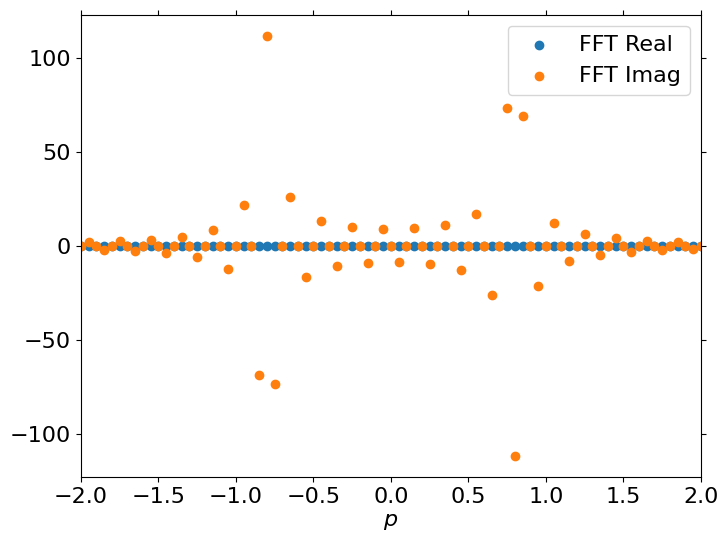

In [ ]:
plt.scatter(numpy.fft.fftfreq(grid.size, d=grid[1]-grid[0]), numpy.fft.fft(psi).real, label='FFT Real')
plt.scatter(numpy.fft.fftfreq(grid.size, d=grid[1]-grid[0]), numpy.fft.fft(psi).imag, label='FFT Imag')
plt.xlim(-2,2)
plt.xlabel('$p$')
plt.legend()
plt.show()

We usually set up the problem so that the bottom of the well goes from $0$ to $L$; then what we want are the sine solutions:

$$\begin{align*}
\psi(x) &= \frac{1}{i}[C \exp(ipx/\hbar) - C\exp(i(-p)x/\hbar)] \\
&= \frac{1}{i}C[\cos(px/\hbar) + i\sin(px/\hbar) - \cos(-px/\hbar) - i\sin(-px/\hbar)] \\
&= \frac{1}{i}C[\cos(px/\hbar) + i\sin(px/\hbar) - \cos(px/\hbar) + i\sin(px/\hbar)] \\
&= 2C\sin(px/\hbar)
\end{align*}
$$

$\psi(0)=0$ naturally here, and the condition $\psi(L) = 0$ forces

$$ \frac{pL}{\hbar} = n\pi $$
$$ p = \frac{n\pi\hbar}{L} $$

So the solutions are

$$\psi_n(x) = \sqrt{\frac{2}{L}} \sin\left[\frac{n\pi}{L}x\right] $$

just as in a usual "standing wave" (the factor $\sqrt{2/L}$ is introduced to make the integral of $|\psi|^2$ equal to one.)  The total energies of the states turn out to be

$$ E_n = \frac{n^2\pi^2\hbar^2}{2mL^2} $$

We're interested in the particle in a box as it can provide a rough model for how particles behave when they are "confined" in a region. So, for example, electrons in a metal can to a certain extent be modeled this way: they are free to move around the metal (it's a conductor), but it is very difficult for them to escape the metal (due to the work function).

Note that we can add any number of solutions $\psi_n$ derived above to get a new valid solution; but all valid solutions can be expressed by summing together the $\psi_n$.  (This property means that the $\psi_n$ form what we call a _basis_ for the solutions.)

## Non-trivial potentials: Simple Harmonic Oscillator

Let's consider a simple harmonic oscillator potential:

$$ V(x) = \frac{1}{2} kx^2 $$

with $k = 0.5$.

In [ ]:
SPRING_CONSTANT=0.5
V = 0.5*SPRING_CONSTANT*grid**2

In [ ]:
P=0
#wave packet
psi=numpy.csingle(scipy.stats.norm(scale=0.4,loc=1).pdf(grid))*numpy.exp(2j*math.pi*P*grid)
# normalize psi
psi /= math.sqrt(sum(psi*psi.conj()).real*(RNG[1]-RNG[0])/(PTS-1))
TRNG=(0,10)
TIMES=numpy.linspace(TRNG[0], TRNG[1], 100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES)
print("Done with integration")
fig, ax = plt.subplots()
# liner, = plt.plot([],[],label='$\Re[\psi]$')
# linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = plt.plot([],[],label='$|\psi|^2$')
plt.plot(grid, V, label='potential energy $V$')
plt.xlim(*RNG)
plt.ylim(-0.5,1.5)
plt.xlabel('$x$')
plt.legend()
def plotter(data):
    global rk
    psii = rk.y[:,data]
#     liner.set_data(grid, psii.real)
#     linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
#     return [liner,linei,linem]
    return [linem]

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
plt.close()
HTML(ani.to_jshtml())

Where is the peak of $|\psi|^2$?

In [ ]:
# Where is the peak of the wavepacket vs time?
psisq = rk.y*rk.y.conj()
maxpos = numpy.argmax(psisq,axis=0)
plt.plot(rk.t, numpy.take_along_axis(grid, maxpos, axis=0))
plt.xlabel('$t$')
plt.ylabel('$x$ position of peak of wavepacket')
plt.show()

From the plot, the motion looks like simple harmonic motion with frequency $\nu \approx$ 1/9. Classically we would expect

$$ \nu = \frac{1}{2\pi}\sqrt{\frac{k}{m}} = 0.1125 \approx 1/9$$

so it seems that the _quantum_ oscillation frequency is the same as the _classical_ one.

We can imagine that we might be able to get a "stationary state" if we carefully chose the initial form of $\psi$. (The technical definition of this is that $\psi(x, t) = e^{i\phi(t)}\psi(x, t_0)$ for all $t$, i.e. $\psi$ changes only by phase with time.) Playing around gives us a solution:

In [ ]:
SPRING_CONSTANT=0.5
V = 0.5*SPRING_CONSTANT*grid**2
P=0
psi=numpy.csingle(scipy.stats.norm(scale=0.4744,loc=0).pdf(grid))*numpy.exp(2j*math.pi*P*grid)
# normalize psi
psi /= math.sqrt(sum(psi*psi.conj()).real*(RNG[1]-RNG[0])/(PTS-1))
TRNG=(0,10)
TIMES=numpy.linspace(TRNG[0], TRNG[1], 100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES)
print("Done with integration")
fig, ax = plt.subplots()
# liner, = plt.plot([],[],label='$\Re[\psi]$')
# linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = plt.plot([],[],label='$|\psi|^2$')
plt.plot(grid, V, label='potential energy $V$')
plt.xlim(*RNG)
plt.ylim(-0.5,1.5)
plt.xlabel('$x$')
plt.legend()
def plotter(data):
    global rk
    psii = rk.y[:,data]
#     liner.set_data(grid, psii.real)
#     linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
#     return [liner,linei,linem]
    return [linem]

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
plt.close()
HTML(ani.to_jshtml())

In fact if one solves for this (and in fact the simple harmonic oscillator is one of the systems where stationary solutions can be solved for exactly) one finds that the _scale_ argument to the normal distribution (i.e., the $\sigma$ parameter) should be 0.4744, which is what we have found by trial and error.


There are other possible stationary states, for example:

In [ ]:
SPRING_CONSTANT=0.5
V = 0.5*SPRING_CONSTANT*grid**2
from scipy.special import hermite
FACTOR = 1/(2**.5*math.pi)**.5
P=0
psi=numpy.csingle(hermite(4)(grid/FACTOR)*scipy.stats.norm(scale=FACTOR,loc=0).pdf(grid))*numpy.exp(2j*math.pi*P*grid)
# normalize psi
psi /= math.sqrt(sum(psi*psi.conj()).real*(RNG[1]-RNG[0])/(PTS-1))
TRNG=(0,10)
TIMES=numpy.linspace(TRNG[0], TRNG[1], 100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES)
print("Done with integration")
fig, ax = plt.subplots()
# liner, = plt.plot([],[],label='$\Re[\psi]$')
# linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = plt.plot([],[],label='$|\psi|^2$')
plt.plot(grid, V, label='potential energy $V$')
plt.xlim(*RNG)
plt.ylim(-0.5,1.5)
plt.xlabel('$x$')
plt.legend()
def plotter(data):
    global rk
    psii = rk.y[:,data]
#     liner.set_data(grid, psii.real)
#     linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
#     return [liner,linei,linem]
    return [linem]

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
plt.close()
HTML(ani.to_jshtml())

Now we can combine different stationary states in a linear combination and see what happens.

In [ ]:
SPRING_CONSTANT=0.5
V = 0.5*SPRING_CONSTANT*grid**2
from scipy.special import hermite
FACTOR = 1/(2**.5*math.pi)**.5
P=0
# define psi1
psi1=numpy.csingle(hermite(0)(grid/FACTOR)*scipy.stats.norm(scale=FACTOR,loc=0).pdf(grid))
# normalize psi1
psi1 /= math.sqrt(sum(psi1*psi1.conj()).real*(RNG[1]-RNG[0])/(PTS-1))
# define psi2
psi2=numpy.csingle(hermite(1)(grid/FACTOR)*scipy.stats.norm(scale=FACTOR,loc=0).pdf(grid))
# normalize psi1
psi2 /= math.sqrt(sum(psi2*psi2.conj()).real*(RNG[1]-RNG[0])/(PTS-1))

psi = (1/2**.5)*psi1+(1j/2**.5)*psi2
TRNG=(0,10)
TIMES=numpy.linspace(TRNG[0], TRNG[1], 100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES)
print("Done with integration")
fig, ax = plt.subplots()
# liner, = plt.plot([],[],label='$\Re[\psi]$')
# linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = plt.plot([],[],label='$|\psi|^2$')
plt.plot(grid, V, label='potential energy $V$')
plt.xlim(*RNG)
plt.ylim(-0.5,4)
plt.xlabel('$x$')
plt.legend()
def plotter(data):
    global rk
    psii = rk.y[:,data]
#     liner.set_data(grid, psii.real)
#     linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
#     return [liner,linei,linem]
    return [linem]

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
plt.close()
HTML(ani.to_jshtml())

## Evolution of Momentum States

We can solve the time-dependent Schr&ouml;dinger's equation explicitly in certain cases. Let us look at what happens to a state of definite momentum in a situation where $V(x) = 0$ everywhere, where we specify the constant $C$ at a time $t=0$:

$$ \psi(x, 0) = C \exp(ipx/\hbar) $$

Then, we wind up with the following equation:

$$\begin{align*}
\frac{\partial\psi}{\partial t} &= \frac{1}{i\hbar}\times -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi \\
&= \frac{i\hbar}{2m} \frac{\partial^2}{\partial x^2} [C \exp(ipx/\hbar)] \\
&= \frac{i\hbar}{2m} \frac{\partial}{\partial x}[C (ip/\hbar)\exp(ipx/\hbar)]\\
&= \frac{i\hbar}{2m} C (ip/\hbar)^2\exp(ipx/\hbar) \\
&= -i \frac{p^2}{2m\hbar} C \exp(ipx/\hbar) \\
&= -i \frac{p^2}{2m\hbar} \psi
\end{align*}$$

which holds for all values of $x$.  From our knowledge of derivatives, we know that the function that has the property that $\partial f/\partial t = K f$ is $f = f(0) \exp(Kt)$ (where $K$ is a constant).  We also know that $p^2/2m = (mv)^2/2m = mv^2/2 $ is the kinetic energy $E$. So we conclude that

$$ \begin{align*}
\psi(x, t) &= \psi(x, 0)\exp(-i\frac{p^2}{2m\hbar}t)\\
&= C\exp(ipx/\hbar)\exp(-iEt/\hbar)\\
&= C\exp(i(px-Et)/\hbar)
\end{align*}
$$

So the solution at all times looks very much like the solution at $t = 0$, except that the wave function is multiplied by $e^{-iEt/\hbar}$.  You will  note this is of the form $e^{i\phi}$, with $\phi$ constant in $x$, so it is just a time-dependent rotation in the complex plane.

In [ ]:
fig, ax = plt.subplots()
liner, = plt.plot([],[],label='$\Re[\psi]$')
linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = plt.plot([],[],label='$|\psi|^2$')
plt.xlim(*RNG)
plt.ylim(-1,1)
plt.xlabel('$x$')
plt.legend()
def plotter(data):
    global rk
#     ax.clear()
#     ax.axis([RNG[0], RNG[1], 0, 4])

    psii = rk.y[:,data]
#    return (plt.plot(grid, (psii*psii.conj()).real),
#            plt.plot(grid, V), plt.plot(psi.real))
    liner.set_data(grid, psii.real)
    linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
    return [liner,linei,linem]
    #return plt.plot(grid, psi.real), plt.plot(grid, psi.imag)

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
#ani.save('wobble.mp4', writer=animation.writers['ffmpeg'](fps=2))
plt.close()
HTML(ani.to_jshtml())

## Tunneling between wells

In [ ]:
RNG=(-10,10)
PTS = 501
grid = numpy.linspace(RNG[0],RNG[1],PTS)[:-1] # drop last point, which wraps to initial point
SPRING_CONSTANT=0.5
V = grid**4 - 0.125*grid**2
from scipy.special import hermite
FACTOR = 1/(2**.5*math.pi)**.5
P=0
# define psi1
psi1=numpy.csingle(hermite(0)(grid/FACTOR)*scipy.stats.norm(scale=FACTOR,loc=-2).pdf(grid))
# normalize psi1
psi1 /= math.sqrt(sum(psi1*psi1.conj()).real*(RNG[1]-RNG[0])/(PTS-1))
# define psi2
psi2=numpy.csingle(hermite(1)(grid/FACTOR)*scipy.stats.norm(scale=FACTOR,loc=0).pdf(grid))
# normalize psi1
psi2 /= math.sqrt(sum(psi2*psi2.conj()).real*(RNG[1]-RNG[0])/(PTS-1))

# psi = (1/2**.5)*psi1+(1j/2**.5)*psi2
psi = psi1

TRNG=(0,10)
TIMES=numpy.linspace(TRNG[0], TRNG[1], 100)
rk=scipy.integrate.solve_ivp(dpsidt, TRNG, psi, t_eval=TIMES)
print("Done with integration")
fig, ax = plt.subplots()
# liner, = plt.plot([],[],label='$\Re[\psi]$')
# linei, = plt.plot([],[],label='$\Im[\psi]$')
linem, = plt.plot([],[],label='$|\psi|^2$')
plt.plot(grid, V, label='potential energy $V$')
plt.xlim(*RNG)
plt.ylim(-0.5,4)
plt.xlabel('$x$')
plt.legend()
def plotter(data):
    global rk
    psii = rk.y[:,data]
#     liner.set_data(grid, psii.real)
#     linei.set_data(grid, psii.imag)
    linem.set_data(grid, (psii*psii.conj()).real)
#     return [liner,linei,linem]
    return [linem]

print("Rendering...")
ani = animation.FuncAnimation(fig, plotter, len(TIMES))
from IPython.display import HTML
plt.close()
HTML(ani.to_jshtml())